GPT = Generative Pre-trained Transformer

generative means the model generates new text

pre-trained means the model was trained on large amounts of data.



A transformer  is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper "Attention Is All You Need". There are a wide variety of models that can be built using transformers: voice-to-text, text-to-voice, text-to-image, machine translation, and many more. The specific variant, which is the type that underlies tools like ChatGPT, is a model trained to take in a piece of text, then produce a prediction of what comes next, in the form of a probability distribution over all chunks of text that might follow.



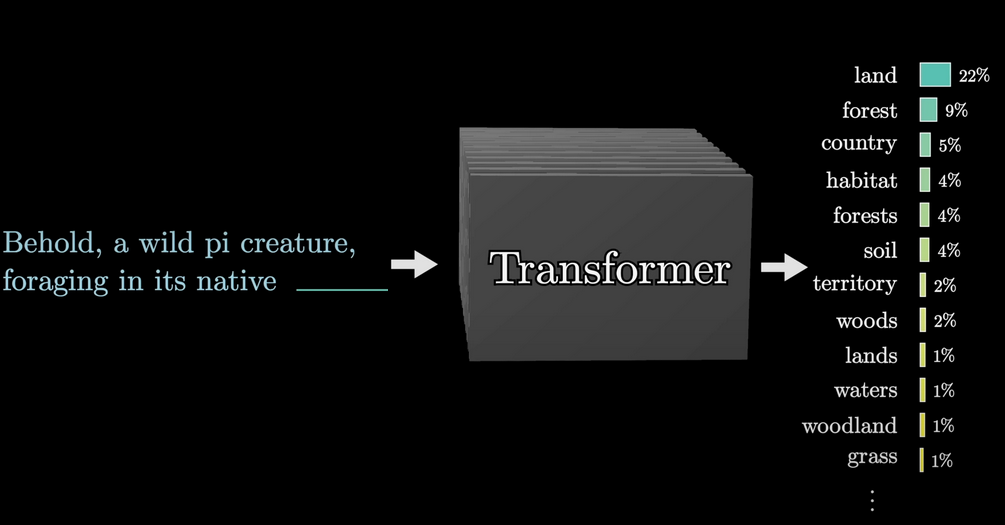

All transformers have the same primary components:

•	Tokenizers, which convert text into tokens.

•	Embedding layer, which converts tokens and positions of the tokens into vector representations.

•	Transformer layers, which carry out repeated transformations on the vector representations, extracting more and more linguistic information. These consist of alternating attention and feedforward layers.

•	Un-embedding layer, which converts the final vector representations back to a probability distribution over the tokens.


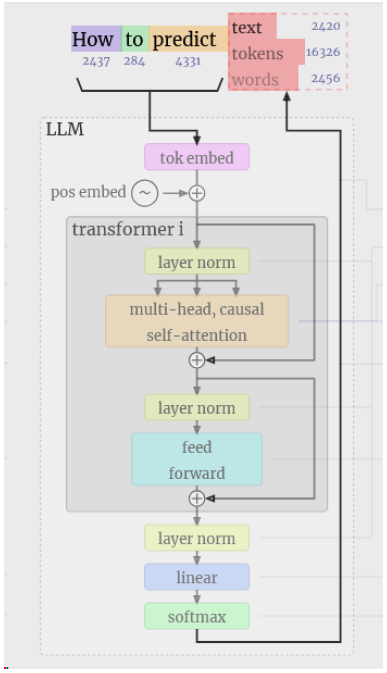

GPT-3 has 175 billion parameters (Large Language Model, LLM)

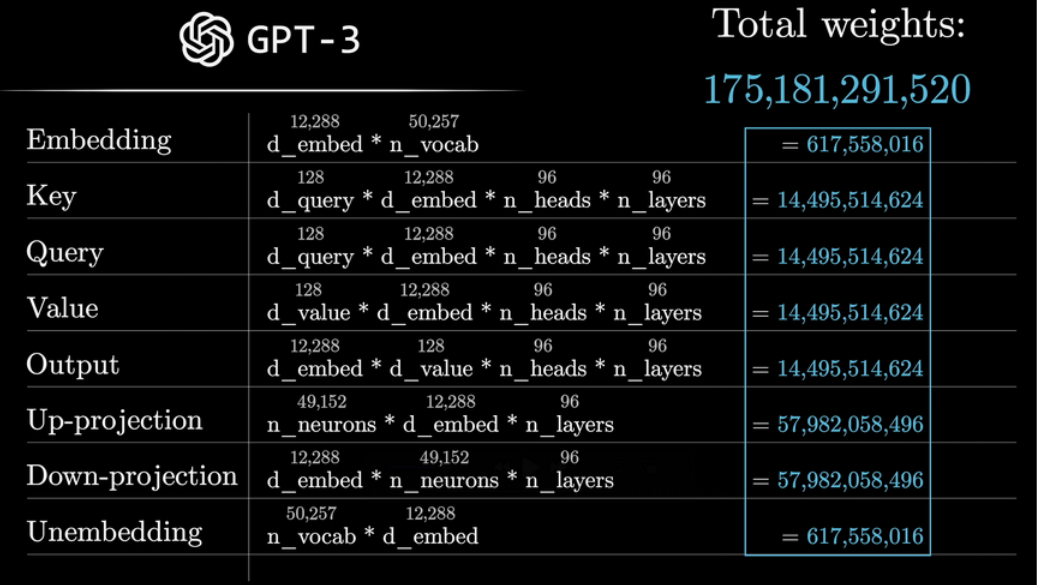


 [3Blue1Brown: Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)

[3Blue1Brown: Transformers (how LLMs work) explained visually](https://www.youtube.com/watch?v=wjZofJX0v4M&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=6)

[3Blue1Brown: Attention in transformers](https://www.youtube.com/watch?v=eMlx5fFNoYc&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=7)

[3Blue1Brown: How might LLMs store facts](https://www.youtube.com/watch?v=9-Jl0dxWQs8&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=8)

[L. Serrano: The Attention Mechanism in Large Language Models](https://www.youtube.com/watch?v=OxCpWwDCDFQ&list=PLs8w1Cdi-zva4fwKkl9EK13siFvL9Wewf)

[L. Serrano: The math behind Attention: Keys, Queries, and Values matrices](https://www.youtube.com/watch?v=UPtG_38Oq8o&list=PLs8w1Cdi-zva4fwKkl9EK13siFvL9Wewf&index=2)

[L. Serrano: What are Transformer Models and how do they work?](https://www.youtube.com/watch?v=qaWMOYf4ri8&list=PLs8w1Cdi-zva4fwKkl9EK13siFvL9Wewf&index=3)


[A. Karpathy: Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)

[Visualization of nanoGPT](https://bbycroft.net/llm)



Code below (written in [PyTorch](https://pytorch.org/)) is a slight modification of [A. Karpathy's code](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py)


**Note:** the matrices in the code  are transposes of the matrices in [Visualization of nanoGPT](https://bbycroft.net/llm)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 128 #B, how many independent sequences will we process in parallel
block_size = 256 #T, what is the maximum context length for predictions
n_embd = 128 #C, embedding length
n_head = 4 # number of heads in transformer block
#head_size = n_embd//n_head
n_layer = 4 # how many transformer blocks

max_iters = 5000 # how many batches in training
eval_interval = 100 # how many batches between loss estimations in training
eval_iters = 200 # how many batches for loss estimation

learning_rate = 1e-3
dropout = 0.3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#load Shakespeare.txt to Colab
with open('Shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
#number of characters in the text
len(text)

1115394

In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
vocab_size = len(chars)
vocab_size

65

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
#and from integers to characters
itos = { i:ch for i,ch in enumerate(chars) }

In [ ]:
stoi

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [ ]:
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [ ]:
print(text[:25])
enc=encode(text[:25])
print()
print(enc)

First Citizen:
Before we 

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1]


In [ ]:
decode(enc)

'First Citizen:\nBefore we '

In [ ]:
# Encode text
encoded_text=encode(text)
data = torch.tensor(encoded_text, dtype=torch.long)
ndata=len(data)
print(data[:1000])
print()
print(ndata)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

In [ ]:
# Train and test split
ntrain = int(0.7*ndata) # first 70% will be train, rest val
train_data = data[:ntrain]
val_data = data[ntrain:]
nval=len(val_data)

print(ntrain)
print(nval)

780775
334619


In [ ]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) #characters
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) #next characters
    x,y = x.to(device), y.to(device)
    return x,y

In [ ]:
x,y = get_batch('train')
print(x.shape)
print(y.shape)

torch.Size([128, 256])
torch.Size([128, 256])


In [ ]:
print(x[0])
print()
print(x[0].shape)

tensor([50,  7, 60, 53, 47, 41, 43, 42,  1, 57, 59, 54, 54, 50, 47, 39, 52, 58,
         1, 51, 39, 49, 43, 57,  1, 58, 46, 47, 57,  1, 43, 39, 45, 43, 56,  1,
        41, 56, 63, 12,  0,  0, 16, 33, 15, 20, 17, 31, 31,  1, 27, 18,  1, 37,
        27, 30, 23, 10,  0, 13,  1, 61, 53, 51, 39, 52,  6,  1, 39, 52, 42,  1,
        58, 46, 63,  1, 39, 59, 52, 58,  6,  1, 45, 56, 43, 39, 58,  1, 49, 47,
        52, 45, 11,  1,  5, 58, 47, 57,  1, 21,  8,  0, 31, 54, 43, 39, 49,  1,
        61, 47, 58, 46,  1, 51, 43,  6,  1, 54, 47, 58, 63,  1, 51, 43,  6,  1,
        53, 54, 43, 52,  1, 58, 46, 43,  1, 42, 53, 53, 56,  8,  0, 13,  1, 40,
        43, 45, 45, 39, 56,  1, 40, 43, 45, 57,  1, 58, 46, 39, 58,  1, 52, 43,
        60, 43, 56,  1, 40, 43, 45, 45,  5, 42,  1, 40, 43, 44, 53, 56, 43,  8,
         0,  0, 20, 17, 26, 30, 37,  1, 14, 27, 24, 21, 26, 19, 14, 30, 27, 23,
        17, 10,  0, 27, 59, 56,  1, 57, 41, 43, 52, 43,  1, 47, 57,  1, 39, 50,
        58, 43, 56,  5, 42,  1, 44, 56, 

In [ ]:
y[0]

tensor([ 7, 60, 53, 47, 41, 43, 42,  1, 57, 59, 54, 54, 50, 47, 39, 52, 58,  1,
        51, 39, 49, 43, 57,  1, 58, 46, 47, 57,  1, 43, 39, 45, 43, 56,  1, 41,
        56, 63, 12,  0,  0, 16, 33, 15, 20, 17, 31, 31,  1, 27, 18,  1, 37, 27,
        30, 23, 10,  0, 13,  1, 61, 53, 51, 39, 52,  6,  1, 39, 52, 42,  1, 58,
        46, 63,  1, 39, 59, 52, 58,  6,  1, 45, 56, 43, 39, 58,  1, 49, 47, 52,
        45, 11,  1,  5, 58, 47, 57,  1, 21,  8,  0, 31, 54, 43, 39, 49,  1, 61,
        47, 58, 46,  1, 51, 43,  6,  1, 54, 47, 58, 63,  1, 51, 43,  6,  1, 53,
        54, 43, 52,  1, 58, 46, 43,  1, 42, 53, 53, 56,  8,  0, 13,  1, 40, 43,
        45, 45, 39, 56,  1, 40, 43, 45, 57,  1, 58, 46, 39, 58,  1, 52, 43, 60,
        43, 56,  1, 40, 43, 45, 45,  5, 42,  1, 40, 43, 44, 53, 56, 43,  8,  0,
         0, 20, 17, 26, 30, 37,  1, 14, 27, 24, 21, 26, 19, 14, 30, 27, 23, 17,
        10,  0, 27, 59, 56,  1, 57, 41, 43, 52, 43,  1, 47, 57,  1, 39, 50, 58,
        43, 56,  5, 42,  1, 44, 56, 53, 

In [ ]:
#Goal of nanoGPT: given a sequence of characters, predict the next character
#one block of training data gives the following training information:
K=10
for k in range(K):
  print(str(k+1)+': previous characters:'+str(x[0][:k+1].tolist())+' -> next character: '+str(y[0][k].tolist()))
print()
print(str(block_size)+': previous characters:'+str(x[0].tolist())+' -> next character: '+str(y[0][-1].tolist()))

1: previous characters:[50] -> next character: 7
2: previous characters:[50, 7] -> next character: 60
3: previous characters:[50, 7, 60] -> next character: 53
4: previous characters:[50, 7, 60, 53] -> next character: 47
5: previous characters:[50, 7, 60, 53, 47] -> next character: 41
6: previous characters:[50, 7, 60, 53, 47, 41] -> next character: 43
7: previous characters:[50, 7, 60, 53, 47, 41, 43] -> next character: 42
8: previous characters:[50, 7, 60, 53, 47, 41, 43, 42] -> next character: 1
9: previous characters:[50, 7, 60, 53, 47, 41, 43, 42, 1] -> next character: 57
10: previous characters:[50, 7, 60, 53, 47, 41, 43, 42, 1, 57] -> next character: 59

256: previous characters:[50, 7, 60, 53, 47, 41, 43, 42, 1, 57, 59, 54, 54, 50, 47, 39, 52, 58, 1, 51, 39, 49, 43, 57, 1, 58, 46, 47, 57, 1, 43, 39, 45, 43, 56, 1, 41, 56, 63, 12, 0, 0, 16, 33, 15, 20, 17, 31, 31, 1, 27, 18, 1, 37, 27, 30, 23, 10, 0, 13, 1, 61, 53, 51, 39, 52, 6, 1, 39, 52, 42, 1, 58, 46, 63, 1, 39, 59, 52, 58, 6

In [ ]:
# nanoGPT-model

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size): # head_size = n_embd//n_head
        super().__init__()
        self.key = nn.Linear(n_embd, head_size) # K_Weights [head_size,n_embd] + K_bias [head_size]
        self.query = nn.Linear(n_embd, head_size) # Q_Weights [head_size,n_embd]  +Q_bias [head_size]
        self.value = nn.Linear(n_embd, head_size) # V_Weights [head_size,n_embd] + V_bias [head_size]
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) #mask, [block_size,block_size], tril = lower triangular
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size [B,T,n_embd]
        # output of size [B,T,head_size]
        B,T,C = x.shape
        K_vectors = self.key(x)   # K_vectors=x@K_weights.T+K_bias, [B,T,head_size]
        Q_vectors = self.query(x) # Q_vectors=x@Q_weights.T+Q_bias, [B,T,head_size]
        # compute attention scores ("affinities")
        Attention_Matrix = Q_vectors @ K_vectors.transpose(-2,-1) * K_vectors.shape[-1]**-0.5 # [B,T,T]
        Attention_Matrix = Attention_Matrix.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # [B,T,T], upper diagonal elements to -infinity
        Attn_Matrix_Softmax = F.softmax(Attention_Matrix, dim=-1) # [B,T,T], exp(-inf) = 0 -> upper diagonal elements = 0
        Attn_Matrix_Softmax = self.dropout(Attn_Matrix_Softmax)
        # perform the weighted aggregation of the values
        V_vectors = self.value(x) # V_vectors=x@V_weights.T+V_bias, [B,T,head_size]
        V_output = Attn_Matrix_Softmax@V_vectors #  [B,T,head_size]
        return V_output

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)]) #self-attention heads
        self.proj = nn.Linear(head_size * n_heads, n_embd) # Projection_Weights [n_embd,n_embd] + Projection_Bias [n_embd]
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        Stack_V_outputs = torch.cat([h(x) for h in self.heads], dim=-1) #stacked V_outputs, [B,T,n_embd]
        Attention_Output = self.proj(Stack_V_outputs) # Attention_output = Stack_V_outputs@Projection_Weights.T+Projection_Bias, [B,T,n_embd]
        Attention_Output = self.dropout(Attention_Output)
        return Attention_Output

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # MLP_weights [4*n_embd,n_embd] + MLP_Bias [4*n_embd]
            nn.GELU(approximate='tanh'), # MLP_Activation, GaussianErrorLinearUnit
            nn.Linear(4 * n_embd, n_embd), # MLP_Projection_Weights [n_embd,4*n_embd] + MLP_Projection_Bias [n_embd]
            nn.Dropout(dropout),
        )

    def forward(self, x): # x = Layer_Norm, [B,T,n_embd]
        return self.net(x) # MLP_Result
        # MLP = x@MLP_weights.T + MLP_Bias, [B,T,4*n_embd]
        # MLP_activation = GELU(MLP), [B,T,4*n_embd]
        # MLP_result = MLP_activation@MLP_Projection_Weights.T+MLP_Projection_Bias, [B,T,n_embd]

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) # layer normalization 1, weight gamma1 [n_embd], bias beta1 [n_embd]
        self.ln2 = nn.LayerNorm(n_embd) # layer normalization 2, weight gamma2 [n_embd], bias beta2 [n_embd]

    def forward(self, x): # x = [B,T,n_embd]
        Layer_Norm1=self.ln1(x) # [B,T,n_embd]
        Attention_Output=self.sa(Layer_Norm1) # [B,T,n_embd]
        Attention_Residual=Attention_Output+x # [B,T,n_embd]
        Layer_Norm2=self.ln2(Attention_Residual) # [B,T,n_embd]
        MLP_Result=self.ffwd(Layer_Norm2) # [B,T,n_embd],
        MLP_Residual=Attention_Residual+MLP_Result # [B,T,n_embd]
        return MLP_Residual

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # transformer blocks
        self.ln_f = nn.LayerNorm(n_embd) # final layer normalization, weight gamma3 [n_embd], bias beta3 [n_embd]
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False) # LM_Head_Weights [vocab_size,n_embd]

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both [B,T] tensors of integers
        Token_Embed = self.token_embedding_table(idx) # [B,T,n_embd]
        Position_Embed = self.position_embedding_table(torch.arange(T, device=device)) # [T,n_embd]
        Input_Embed = Token_Embed + Position_Embed # [B,T,n_embd]
        Final_MLP_Residual = self.blocks(Input_Embed) # [B,T,n_embd]
        Final_Layer_Norm = self.ln_f(Final_MLP_Residual) # [B,T,n_embd]
        logits = self.lm_head(Final_Layer_Norm) # logits = Final_Layer_Norm@LM_Head_Weights.T, [B,T,vocab_size]

        if targets is None:
            loss = None
        else:
            B,T,vs = logits.shape #vs = vocab_size
            logits = logits.view(B*T,vs) #[B,T,vs] -> [B*T,vs]
            targets = targets.view(B*T) #[B,T] -> [B*T]
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_characters):
      #idx is [B,T] array of indices in the current context
      for _ in range(max_new_characters):
          # crop idx to the last block_size tokens
          idx_cond = idx[:, -block_size:]
          # get the predictions
          logits, loss = self(idx_cond) #Logits = [B,T,vocab_size]
          # focus only on the last time step
          logits = logits[:, -1, :] # becomes [B,vocab_size]
          # apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # [B,vocab_size]
          # sample from the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # [B,1]
          # append sampled index to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # [B,T+1]
      return idx



In [ ]:
model = GPTLanguageModel().to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), ' parameters')

842752  parameters


In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad: #trainable parameters
    print(name)
    print(param.data.shape)

token_embedding_table.weight
torch.Size([65, 128])
position_embedding_table.weight
torch.Size([256, 128])
blocks.0.sa.heads.0.key.weight
torch.Size([32, 128])
blocks.0.sa.heads.0.key.bias
torch.Size([32])
blocks.0.sa.heads.0.query.weight
torch.Size([32, 128])
blocks.0.sa.heads.0.query.bias
torch.Size([32])
blocks.0.sa.heads.0.value.weight
torch.Size([32, 128])
blocks.0.sa.heads.0.value.bias
torch.Size([32])
blocks.0.sa.heads.1.key.weight
torch.Size([32, 128])
blocks.0.sa.heads.1.key.bias
torch.Size([32])
blocks.0.sa.heads.1.query.weight
torch.Size([32, 128])
blocks.0.sa.heads.1.query.bias
torch.Size([32])
blocks.0.sa.heads.1.value.weight
torch.Size([32, 128])
blocks.0.sa.heads.1.value.bias
torch.Size([32])
blocks.0.sa.heads.2.key.weight
torch.Size([32, 128])
blocks.0.sa.heads.2.key.bias
torch.Size([32])
blocks.0.sa.heads.2.query.weight
torch.Size([32, 128])
blocks.0.sa.heads.2.query.bias
torch.Size([32])
blocks.0.sa.heads.2.value.weight
torch.Size([32, 128])
blocks.0.sa.heads.2.value.b

In [ ]:
#for training to calculate losses and accuracies
@torch.no_grad() #no backpropagation used
def estimate_loss():
    losses = {}
    accuracies={}
    model.eval() #model to evaluation (prediction) phase
    for split in ['train', 'val']:
        loss_split = torch.zeros(eval_iters)
        correct_split=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            loss_split[k] = loss.item()
            logits=logits.view(batch_size,block_size, vocab_size) #[batch_size*block_size,vocab_size] -> [batch_size,block_size,vocab_size]
            predictions=torch.argmax(logits,axis=-1) #predicted next characters
            correct_split[k]=(predictions==Y).sum().item() #number of correct predictions
        losses[split] = loss_split.mean()
        accuracies[split]=correct_split.sum()/(eval_iters*batch_size*block_size)
    model.train() #model to training phase
    return losses, accuracies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for training create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# training the model, use GPU

best_val_acc=0

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses, accuracies  = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, train acc {accuracies['train']:.4f}, val loss {losses['val']:.4f}, val acc {accuracies['val']:.4f}")
        if accuracies['val']>best_val_acc:
          best_val_acc=accuracies['val']
          torch.save(model.state_dict(), '/content/drive/MyDrive/nanoGPT.pt') #save best weights
          print('saved')

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb) #forward propagation
    optimizer.zero_grad(set_to_none=True) #clear previous derivates
    loss.backward() #backpropagation
    optimizer.step() #update parameters

step 0: train loss 4.1818, train acc 0.0132, val loss 4.1815, val acc 0.0132
saved
step 100: train loss 2.5270, train acc 0.2732, val loss 2.5597, val acc 0.2640
saved
step 200: train loss 2.4310, train acc 0.2853, val loss 2.4793, val acc 0.2728
saved
step 300: train loss 2.2647, train acc 0.3340, val loss 2.3382, val acc 0.3139
saved
step 400: train loss 2.0676, train acc 0.3895, val loss 2.1737, val acc 0.3626
saved
step 500: train loss 1.9013, train acc 0.4336, val loss 2.0531, val acc 0.3976
saved
step 600: train loss 1.7920, train acc 0.4622, val loss 1.9867, val acc 0.4203
saved
step 700: train loss 1.7073, train acc 0.4838, val loss 1.9455, val acc 0.4356
saved
step 800: train loss 1.6472, train acc 0.5016, val loss 1.9191, val acc 0.4502
saved
step 900: train loss 1.5989, train acc 0.5141, val loss 1.8921, val acc 0.4590
saved
step 1000: train loss 1.5613, train acc 0.5237, val loss 1.8678, val acc 0.4667
saved
step 1100: train loss 1.5194, train acc 0.5336, val loss 1.8433, v

In [ ]:
#define GPTLanguageModel and load saved weights

#using CPU
model.load_state_dict(torch.load('/content/drive/MyDrive/nanoGPT.pt', weights_only=True, map_location=torch.device('cpu')))

#using GPU
#model.load_state_dict(torch.load('/content/drive/MyDrive/nanoGPT.pt', weights_only=True))

model.eval()

GPTLanguageModel(
  (token_embedding_table): Embedding(65, 128)
  (position_embedding_table): Embedding(256, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=True)
            (query): Linear(in_features=128, out_features=32, bias=True)
            (value): Linear(in_features=128, out_features=32, bias=True)
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='tanh')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, eleme

In [ ]:
#save parameters to files for nanoGPT_in_NumPy.ipynb
import numpy as np
for name, param in model.named_parameters():
  if param.requires_grad: #trainable parameters
    np.savetxt('/content/drive/MyDrive/nanoGPT_parameters/'+str(name)+'.txt',param.data.detach().numpy())

In [ ]:
#generate new characters from the model
#context = torch.zeros((1, 1), dtype=torch.long, device=device)
context = torch.tensor([encode('to be or not to b')], dtype=torch.long, device=device)
max_new_characters=1000
new_characters=model.generate(context, max_new_characters)
print(decode(new_characters[0].tolist()))

to be or not to bean him.

QUEEN ELIZABETH:
You shall be proclaim'd partly, and the wretched
To tie your daughter's majesty, you ransgrife.

KING RICHARD III:
When, then you were you land my tongue day?

QUEEN ELIZABETH:
The sheeping Edward was no? the gains the either
Except the title partuous eyes:
And favourable those heads bears may approid.

KING RICHARD II:
That what?

KING RICHARD III:
My lords, stand always my son!

QUEEN ELIZABETH:
And will I say, it prove my town, be sight.

KING RICHARD II:
O is that I will be infantanced there!

KING RICHARD III:
Now, ammy soul I be changed up, that I entain'd to what it,
To make be cursed time that it spring and this stars
That softly stain and bloody dreams was for't.

RICHARD:
No, and returns I am to me;
Without why proclaimitation?
Had thou art, desire with him; they're
And councils doth not such a gentle Duke of York.
Madam, when dost thou, Princes, get those death supper:
Let me after his coursel the wruth of Buckingham;
And are in si

In [ ]:
input=encode('to be or not to b')
input_tensor=torch.tensor([input], dtype=torch.long, device=device)
logits, loss = model(input_tensor)
print(logits)
print()
print(loss)
print()
print(logits.shape)

tensor([[[ 1.3361,  3.9731, -0.0534,  ..., -4.2343,  0.8642, -4.0693],
         [ 1.8269,  6.1090, -0.4381,  ..., -3.1821,  0.3846, -2.8366],
         [-5.0449, -2.1933, -5.4169,  ..., -4.9472,  2.5514, -5.1547],
         ...,
         [ 3.7025,  7.7445, -0.2910,  ..., -1.9965, -0.4491, -2.3262],
         [-5.2937, -2.4237, -6.1262,  ..., -4.7984,  2.3930, -5.5151],
         [-0.3841,  0.8127, -3.7892,  ..., -1.0713,  3.2196, -6.6096]]],
       grad_fn=<UnsafeViewBackward0>)

None

torch.Size([1, 17, 65])


In [ ]:
print(logits[0,-1,:]) #logits for the last prediction

tensor([ -0.3841,   0.8127,  -3.7892,  -6.9160,  -7.6446,  -1.0264,  -1.5265,
         -2.2550,  -0.8283,  -6.2540,  -2.6090,  -1.6437,  -2.8553,  -3.4533,
        -10.3075, -10.2621,  -9.5742,  -3.7889,  -9.3753, -10.6653,  -8.6116,
         -5.3280,  -7.2958,  -8.2277,  -5.3243,  -8.3317, -11.4998,  -6.5055,
        -10.1840,  -9.1723,  -2.0291,  -9.8591,  -8.1882,  -3.3083, -12.7487,
        -10.8516, -12.9145,  -6.7992, -10.6200,   5.8239,  -1.1298,  -1.7308,
         -0.6063,   9.6564,  -3.1904,  -1.1234,   1.7360,   5.8355,  -2.8330,
         -1.4051,   5.9165,  -0.2150,  -0.0887,   5.2845,  -2.4494,  -4.7781,
          6.8170,   0.1104,   0.7736,   5.9586,  -2.0045,  -0.3594,  -1.0713,
          3.2196,  -6.6096], grad_fn=<SliceBackward0>)


In [ ]:
probs=F.softmax(logits[0,-1,:],dim=0) #probabilities for the last prediction
print(probs)

tensor([3.7394e-05, 1.2375e-04, 1.2416e-06, 5.4456e-08, 2.6279e-08, 1.9671e-05,
        1.1931e-05, 5.7579e-06, 2.3982e-05, 1.0557e-07, 4.0413e-06, 1.0611e-05,
        3.1590e-06, 1.7373e-06, 1.8328e-09, 1.9180e-09, 3.8159e-09, 1.2420e-06,
        4.6555e-09, 1.2816e-09, 9.9913e-09, 2.6649e-07, 3.7245e-08, 1.4668e-08,
        2.6749e-07, 1.3219e-08, 5.5633e-10, 8.2095e-08, 2.0737e-09, 5.7035e-09,
        7.2177e-06, 2.8698e-09, 1.5258e-08, 2.0082e-06, 1.5955e-10, 1.0637e-09,
        1.3518e-10, 6.1202e-08, 1.3409e-09, 1.8573e-02, 1.7739e-05, 9.7263e-06,
        2.9943e-05, 8.5766e-01, 2.2596e-06, 1.7853e-05, 3.1155e-04, 1.8789e-02,
        3.2303e-06, 1.3471e-05, 2.0376e-02, 4.4281e-05, 5.0242e-05, 1.0830e-02,
        4.7405e-06, 4.6184e-07, 5.0143e-02, 6.1312e-05, 1.1901e-04, 2.1252e-02,
        7.3974e-06, 3.8329e-05, 1.8808e-05, 1.3736e-03, 7.3974e-08],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
ind=probs.argmax().item() #index of maximum probability
print(ind)

43


In [ ]:
probs[ind].item() #maximum probability

0.857656717300415

In [ ]:
decode([ind]) #predicted next character

'e'

In [ ]:
split='val'
X, Y = get_batch(split)
logits, loss = model(X,Y)
print(logits)
print()
print(logits.shape)
print()
print(loss)
print()
print(loss.item())

tensor([[ 0.3741,  3.1169, -0.7000,  ..., -3.7591,  0.9226, -4.4309],
        [-1.2296,  0.7072, -1.4229,  ..., -2.6041,  2.6509, -0.9906],
        [ 5.1290,  9.3584,  3.2647,  ..., -6.8232,  1.0830, -6.1820],
        ...,
        [-6.2651, -2.3896, -6.3458,  ..., -4.6310,  0.1275, -3.9257],
        [-5.9494, -2.0738, -5.4262,  ...,  0.3715,  4.9717,  0.6606],
        [-2.2150,  2.2159, -4.2558,  ..., -5.6517,  0.2814, -5.3245]],
       grad_fn=<ViewBackward0>)

torch.Size([32768, 65])

tensor(1.6983, grad_fn=<NllLossBackward0>)

1.6983281373977661


In [ ]:
logits=logits.view(batch_size,block_size, vocab_size) #[batch_size*block_size,vocab_size] -> [batch_size,block_size,vocab_size]
print(logits)
print()
print(logits.shape)

tensor([[[ 3.7407e-01,  3.1169e+00, -6.9999e-01,  ..., -3.7591e+00,
           9.2256e-01, -4.4309e+00],
         [-1.2296e+00,  7.0718e-01, -1.4229e+00,  ..., -2.6041e+00,
           2.6509e+00, -9.9062e-01],
         [ 5.1290e+00,  9.3584e+00,  3.2647e+00,  ..., -6.8232e+00,
           1.0830e+00, -6.1820e+00],
         ...,
         [-5.5856e+00, -2.5870e+00, -6.6781e+00,  ..., -5.1957e+00,
           2.7801e+00, -5.7868e+00],
         [-3.1637e+00, -5.7684e-01, -5.5649e+00,  ..., -4.1931e+00,
           4.5094e+00, -7.9460e+00],
         [-1.3780e+00,  1.5246e+00,  2.1912e+00,  ..., -2.1026e+00,
           1.7905e-01,  9.7030e-01]],

        [[-1.9994e+00, -4.4626e-01, -3.3868e+00,  ..., -4.0362e+00,
           1.1249e+00, -4.0689e+00],
         [-1.8597e+00,  1.3303e+00, -3.0241e+00,  ..., -4.7126e+00,
           3.1764e+00, -5.8494e+00],
         [-2.3835e+00, -8.5376e-01, -3.9549e+00,  ...,  8.9844e-01,
          -1.8288e+00,  4.5203e-01],
         ...,
         [-5.2979e+00, -2

In [ ]:
predictions=torch.argmax(logits,axis=-1) #predicted next characters
print(predictions)
print()
print(predictions.shape)

tensor([[ 1, 59,  1,  ..., 39, 43, 58],
        [58, 46, 51,  ..., 43, 61, 42],
        [21, 17, 33,  ..., 44,  1, 58],
        ...,
        [52, 57,  1,  ..., 61, 57,  1],
        [43,  1, 57,  ...,  1, 57, 53],
        [ 1, 13, 46,  ..., 53, 41, 43]])

torch.Size([128, 256])


In [ ]:
print(Y)
print()
print(Y.shape)

tensor([[53, 51, 47,  ..., 46, 39, 60],
        [58, 47, 51,  ..., 43, 43, 42],
        [32, 21, 27,  ..., 44,  1, 44],
        ...,
        [43, 58,  8,  ..., 47, 58,  1],
        [43,  1, 58,  ...,  1, 58, 39],
        [ 0, 32, 53,  ..., 39, 44, 43]])

torch.Size([128, 256])


In [ ]:
predictions==Y

tensor([[False, False, False,  ..., False, False, False],
        [ True, False,  True,  ...,  True, False,  True],
        [False, False, False,  ...,  True,  True, False],
        ...,
        [False, False, False,  ..., False, False,  True],
        [ True,  True, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False,  True]])

In [ ]:
correct=(predictions==Y).sum().item()
print(correct)
print(correct/(batch_size*block_size))

17584
0.53662109375


In [ ]:
last_preds=predictions[:,-1] #last new character predictions
print(last_preds)
print()
print(last_preds.shape)

tensor([58, 42, 58, 39, 50, 43, 58,  8, 57,  1, 52, 58, 47, 63, 52,  1,  1, 40,
        43, 53, 53, 56, 52,  1, 43, 42,  1, 57, 53,  1,  0, 53, 56, 51, 58, 15,
        58, 57, 56, 47, 46,  1,  1, 63,  1, 32,  1, 43, 52, 53, 46, 53,  1, 39,
        43,  0, 44, 15, 58, 47, 58, 61,  1, 53, 46, 58, 25, 51, 44, 39, 39,  1,
        51, 56, 53,  1, 33, 58, 63, 57, 41, 51, 50,  0, 46, 32, 46, 43,  1, 39,
        59,  1, 39, 53, 17, 43, 58, 54,  1, 57, 53, 57, 46,  1, 28, 43,  0, 47,
        63, 45, 52,  0, 61,  1, 47, 61, 30, 39, 52, 47, 58, 39, 46, 43, 52,  1,
        53, 43])

torch.Size([128])


In [ ]:
Y[:,-1]

tensor([60, 42, 44, 53, 50, 43, 50,  8, 57,  1, 52, 46, 47, 52, 52,  1,  1, 53,
        43, 53, 53, 56, 52,  1, 53, 42,  1,  1, 53, 56,  0, 53, 57, 57, 46, 23,
        58, 42, 52, 47, 46,  1,  6, 39,  1, 35,  1, 43, 52, 53, 58, 47,  8, 39,
        43, 31, 44, 14, 56, 47, 58, 49, 10, 51, 43, 46, 32, 51, 44, 39, 39,  1,
        51, 57, 53,  1, 33, 63, 63, 39, 50, 57, 50,  0, 46, 13, 46, 43,  5, 63,
        59,  1, 58, 47, 37, 43, 58, 54,  1,  1, 53, 57, 46,  1, 15, 43, 35, 47,
        63, 42, 52,  0, 41,  1, 39, 58, 31, 43, 50, 53, 58, 39, 46, 53, 52,  1,
        39, 43])

In [ ]:
correct=(last_preds==Y[:,-1]).sum().item()
print(correct)
print(correct/batch_size)

73
0.5703125
